# Checking AWS Enviornment
Note: I had to spool an ubuntu instance because pulp wasnt working locally

In [1]:
import requests
import os
import io


def get_instance_type():
    """Get the EC2 instance type."""
    response = requests.get("http://169.254.169.254/latest/meta-data/instance-type")
    return response.text

def get_ram_details():
    """Get RAM details using a system command."""
    total_mib = os.popen("free -m | awk 'NR==2{print $2}'").read().strip()
    return f"{total_mib} MiB"

def get_processor_info():
    """Get processor information."""
    processor_info = os.popen("grep 'model name' /proc/cpuinfo | uniq").read().strip()
    return processor_info.split(":")[1].strip()

instance_type = get_instance_type()
ram_details = get_ram_details()
processor_info = get_processor_info()

print(f"Instance Type: {instance_type}")
print(f"RAM: {ram_details}")
print(f"Processor Info: {processor_info}")

Instance Type: <HTML>
  <HEAD>
     Access Denied
  </HEAD>
<BODY>

<h1>Access Denied</h1>

<p>
Access to arbitrary websites is not available from free accounts;
you can only access sites that are on our
<a href="http://www.pythonanywhere.com/whitelist">whitelist</a>.
If you want to suggest something to add to our whitelist
drop us a line at nbusercare@pythonanywhere.com.  It will have
to have an official public API.
</p>


<p>
Alternatively, you can sign up for a paid account at
<a href="http://www.pythonanywhere.com/account/">http://www.pythonanywhere.com/account/</a>
</p>
<p>
If you have already got a paid account and you're still getting this messge,
you may need to reload your web app (from the "Web" tab) or restart
your consoles.  If that doesn't help, drop us a line at nbusercare@pythonanywhere.com.
</p>

</BODY>

RAM: 31641 MiB
Processor Info: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz


# Loading Provided Dataset. 
Note: This is cleaned up data from Lawler_Jensen_ProjectPlan 10_18.xlsx

In [5]:
import pandas as pd
import pulp

df = pd.read_excel("data.xlsx")
df['predecessorTaskIDs'].fillna("", inplace=True)
df = df[['taskID', 'task', 'predecessorTaskIDs', 'bestCaseHours', 'expectedHours', 'worstCaseHours']]
df

,taskID,task,predecessorTaskIDs,bestCaseHours,expectedHours,worstCaseHours
0,A,Describe product,,1,2,3
1,B,Develop marketing strategy,,1,2,4
2,C,Design brochure,A,2,4,6
3,D1,Requirements analysis,A,2,4,8
4,D2,Software design,D1,10,16,24
5,D3,System design,D1,10,16,24
6,D4,Coding,"D2, D3",10,16,24
7,D5,Write documentation,D4,2,4,8
8,D6,Unit testing,D4,16,24,32
9,D7,System testing,D6,16,24,32


# Defining Linear Programming Function

In [7]:
def solve_project_plan(df, case="expected"):
    # LP Model
    lp_problem = pulp.LpProblem("Project_Planning", pulp.LpMinimize)
    
    # Decision vars
    start_times = pulp.LpVariable.dicts("start_time", df["taskID"], 0, None)
    
    # Objective function
    project_end = pulp.LpVariable("project_end", 0, None)
    lp_problem += project_end, "Minimize_Project_Duration"
    
    # adding constraints
    for index, row in df.iterrows():
        task = row["taskID"]
        
        # duration of cases
        if case == "best":
            duration = row["bestCaseHours"]
        elif case == "worst":
            duration = row["worstCaseHours"]
        else:
            duration = row["expectedHours"]
        
        predecessors = [pred.strip() for pred in row["predecessorTaskIDs"].split(",") if pred.strip()]
        
        # task duration constraint
        lp_problem += start_times[task] + duration <= project_end
        
        # task dependencies constraints
        for predecessor in predecessors:
            lp_problem += start_times[task] >= start_times[predecessor] + duration

    # Solver
    lp_problem.solve()
    
    # output prep
    results = {
        "status": pulp.LpStatus[lp_problem.status],
        "optimal_duration": project_end.varValue,
        "task_start_times": {task: var.varValue for task, var in start_times.items()}
    }
    
    return results

# Running Linear Solver and Saving Results
Note: The output below is saved to results_lp_output.txt <br>
Note: The output dataframe is saved to results_lp.csv

In [9]:
simple_results_df = pd.DataFrame(columns=["Case", "Optimal_Duration", *df["taskID"].tolist()])
output_buffer = io.StringIO()

cases = ["best", "expected", "worst"]
for case in cases:
    result = solve_project_plan(df, case)
    
    print_str = f"Results for {case} case:\n"
    print_str += f"Optimal project duration: {result['optimal_duration']} hours\n"
    print_str += "Start times for tasks:\n"
    for task, start_time in result["task_start_times"].items():
        print_str += f"Task {task}: {start_time} hours\n"
    print_str += "\n"
    
    row_data = [case, result["optimal_duration"]] + list(result["task_start_times"].values())
    simple_results_df.loc[len(simple_results_df)] = row_data
    
    output_buffer.write(print_str)

with open("results_lp_output.txt", "w") as f:
    f.write(output_buffer.getvalue())

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/daf03834-2cd7-40ad-bc31-d3b51e4b5c9f/.local/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/cbb0021adb204c3aac53571aab3f47a6-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/cbb0021adb204c3aac53571aab3f47a6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 109 RHS
At line 144 BOUNDS
At line 145 ENDATA
Problem MODEL has 34 rows, 16 columns and 68 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-34) rows, 0 (-16) columns and 0 (-68) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 70
After Postsolve, objective 70, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 70 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock

In [11]:
simple_results_df.to_csv("results_lp.csv")
simple_results_df

,Case,Optimal_Duration,A,B,C,D1,D2,D3,D4,D5,D6,D7,D8,E,F,G,H
0,best,70.0,0.0,0.0,2.0,2.0,12.0,12.0,22.0,24.0,38.0,54.0,56.0,8.0,57.0,57.0,68.0
1,expected,108.0,0.0,0.0,4.0,4.0,20.0,20.0,36.0,40.0,60.0,84.0,88.0,14.0,90.0,90.0,104.0
2,worst,152.0,0.0,0.0,6.0,8.0,32.0,32.0,56.0,64.0,88.0,120.0,126.0,22.0,130.0,130.0,144.0


# Critical Path and Gantt Chart for Best Case Solution


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/daf03834-2cd7-40ad-bc31-d3b51e4b5c9f/.local/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c012c4fe5ce94cd1b762ed5f318cba41-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/c012c4fe5ce94cd1b762ed5f318cba41-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 109 RHS
At line 144 BOUNDS
At line 145 ENDATA
Problem MODEL has 34 rows, 16 columns and 68 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-34) rows, 0 (-16) columns and 0 (-68) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 70
After Postsolve, objective 70, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 70 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock

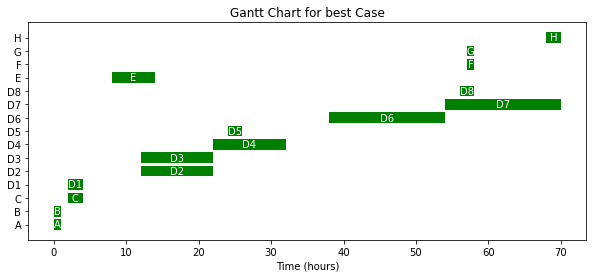

In [32]:
import io
import matplotlib.pyplot as plt

# Define a function to identify the critical path based on start times
def identify_critical_path(df, results, case="best"):
    optimal_duration = results["optimal_duration"]
    task_start_times = results["task_start_times"]
    
    critical_path = []

    for index, row in df.iterrows():
        task = row["taskID"]
        duration = None

        # Determine the duration based on the scenario
        if results["status"] == "Optimal":
            if case == "best":
                duration = row["bestCaseHours"]
            elif case == "worst":
                duration = row["worstCaseHours"]
            else:
                duration = row["expectedHours"]

        # Calculate the task end time
        task_end_time = task_start_times[task] + duration

        # If the task ends at the project's optimal duration, it's on the critical path
        if task_end_time == optimal_duration:
            critical_path.append(task)

    return critical_path

# Identify and print the critical path for the "best" case
case = "best"
result = solve_project_plan(df, case)
critical_path = identify_critical_path(df, result, case)

print(f"Critical Path for {case} case: {critical_path}")
case = "best"


# Define a function to create a Gantt chart
def create_gantt_chart(df, results, case="best"):
    task_start_times = results["task_start_times"]
    task_durations = {}
    
    for index, row in df.iterrows():
        task = row["taskID"]
        if case == "best":
            task_durations[task] = row["bestCaseHours"]
        else:
            task_durations[task] = row["expectedHours"]

    tasks = list(task_start_times.keys())
    start_times = [task_start_times[task] for task in tasks]
    durations = [task_durations[task] for task in tasks]

    fig, ax = plt.subplots(figsize=(10, 4))
    
    for i, task in enumerate(tasks):
        ax.broken_barh([(start_times[i], durations[i])], (i - 0.4, 0.8), facecolors='green')
        ax.text(start_times[i] + durations[i] / 2, i, task, ha='center', va='center', color='white')

    ax.set_yticks(range(len(tasks)))
    ax.set_yticklabels(tasks)
    ax.set_xlabel('Time (hours)')
    ax.set_title(f'Gantt Chart for {case} Case')

    plt.show()

result = solve_project_plan(df, case)
create_gantt_chart(df, result, case)


# Critical Path and Gantt Chart for Expected Solution


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/daf03834-2cd7-40ad-bc31-d3b51e4b5c9f/.local/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/62c5f95685b0458e89dabeb0737d866b-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/62c5f95685b0458e89dabeb0737d866b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 109 RHS
At line 144 BOUNDS
At line 145 ENDATA
Problem MODEL has 34 rows, 16 columns and 68 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-34) rows, 0 (-16) columns and 0 (-68) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 108
After Postsolve, objective 108, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 108 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallcl

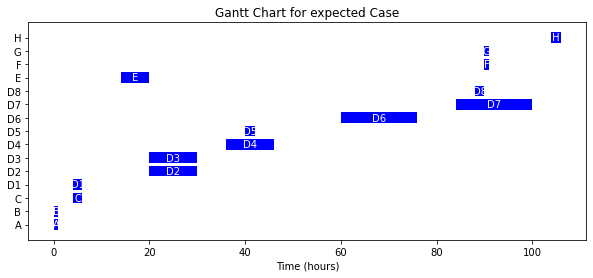

In [34]:
def identify_critical_path(df, results, case="expected"):
    optimal_duration = results["optimal_duration"]
    task_start_times = results["task_start_times"]
    
    critical_path = []

    for index, row in df.iterrows():
        task = row["taskID"]
        duration = None

        # Determine the duration based on the scenario
        if results["status"] == "Optimal":
            if case == "expected":
                duration = row["bestCaseHours"]
            elif case == "worst":
                duration = row["worstCaseHours"]
            else:
                duration = row["expectedHours"]

        # Calculate the task end time
        task_end_time = task_start_times[task] + duration

        # If the task ends at the project's optimal duration, it's on the critical path
        if task_end_time == optimal_duration:
            critical_path.append(task)

    return critical_path

# Identify and print the critical path for the "best" case
case = "expected"
result = solve_project_plan(df, case)
critical_path = identify_critical_path(df, result, case)

print(f"Critical Path for {case} case: {critical_path}")
case = "expected"


# Define a function to create a Gantt chart
def create_gantt_chart(df, results, case="expected"):
    task_start_times = results["task_start_times"]
    task_durations = {}
    
    for index, row in df.iterrows():
        task = row["taskID"]
        if case == "expected":
            task_durations[task] = row["bestCaseHours"]
        else:
            task_durations[task] = row["expectedHours"]

    tasks = list(task_start_times.keys())
    start_times = [task_start_times[task] for task in tasks]
    durations = [task_durations[task] for task in tasks]

    fig, ax = plt.subplots(figsize=(10, 4))
    
    for i, task in enumerate(tasks):
        ax.broken_barh([(start_times[i], durations[i])], (i - 0.4, 0.8), facecolors='blue')
        ax.text(start_times[i] + durations[i] / 2, i, task, ha='center', va='center', color='white')

    ax.set_yticks(range(len(tasks)))
    ax.set_yticklabels(tasks)
    ax.set_xlabel('Time (hours)')
    ax.set_title(f'Gantt Chart for {case} Case')

    plt.show()

result = solve_project_plan(df, case)
create_gantt_chart(df, result, case)

# Critical Path and Gantt Chart for Worst Case Solution


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/daf03834-2cd7-40ad-bc31-d3b51e4b5c9f/.local/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1d6f0be67a04464aa9874b5ba01c99f1-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/1d6f0be67a04464aa9874b5ba01c99f1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 39 COLUMNS
At line 109 RHS
At line 144 BOUNDS
At line 145 ENDATA
Problem MODEL has 34 rows, 16 columns and 68 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-34) rows, 0 (-16) columns and 0 (-68) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 152
After Postsolve, objective 152, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 152 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallcl

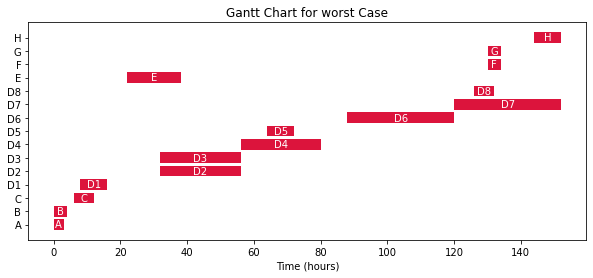

In [36]:
def identify_critical_path(df, results, case="worst"):
    optimal_duration = results["optimal_duration"]
    task_start_times = results["task_start_times"]
    
    critical_path = []

    for index, row in df.iterrows():
        task = row["taskID"]
        duration = None

        # Determine the duration based on the scenario
        if results["status"] == "Optimal":
            if case == "expected":
                duration = row["bestCaseHours"]
            elif case == "worst":
                duration = row["worstCaseHours"]
            else:
                duration = row["expectedHours"]

        # Calculate the task end time
        task_end_time = task_start_times[task] + duration

        # If the task ends at the project's optimal duration, it's on the critical path
        if task_end_time == optimal_duration:
            critical_path.append(task)

    return critical_path

# Identify and print the critical path for the "best" case
case = "worst"
result = solve_project_plan(df, case)
critical_path = identify_critical_path(df, result, case)

print(f"Critical Path for {case} case: {critical_path}")
case = "worst"


# Define a function to create a Gantt chart
def create_gantt_chart(df, results, case="worst"):
    task_start_times = results["task_start_times"]
    task_durations = {}
    
    for index, row in df.iterrows():
        task = row["taskID"]
        if case == "worst":
            task_durations[task] = row["worstCaseHours"]
        else:
            task_durations[task] = row["expectedHours"]

    tasks = list(task_start_times.keys())
    start_times = [task_start_times[task] for task in tasks]
    durations = [task_durations[task] for task in tasks]

    fig, ax = plt.subplots(figsize=(10, 4))
    
    for i, task in enumerate(tasks):
        ax.broken_barh([(start_times[i], durations[i])], (i - 0.4, 0.8), facecolors='crimson')
        ax.text(start_times[i] + durations[i] / 2, i, task, ha='center', va='center', color='white')

    ax.set_yticks(range(len(tasks)))
    ax.set_yticklabels(tasks)
    ax.set_xlabel('Time (hours)')
    ax.set_title(f'Gantt Chart for {case} Case')

    plt.show()

result = solve_project_plan(df, case)
create_gantt_chart(df, result, case)